In [ ]:
# Install the required libraries
#SAM
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install -q datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
# !pip install -q patchify
#Nibabel tp open .nii files
!pip install -q nibabel

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00


In [ ]:
import nibabel as nib
import monai

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
from tqdm import tqdm
from statistics import mean
from sklearn.preprocessing import MinMaxScaler

import random
from time import sleep
from IPython.display import clear_output

from datasets import Dataset
from PIL import Image

from transformers import SamProcessor
from transformers import SamModel, SamConfig, SamProcessor

import torch
from torch.utils.data import DataLoader
from torch.nn.functional import threshold, normalize,interpolate
from torch.optim import Adam

## Patient 1

T2 + Core + Penumbra


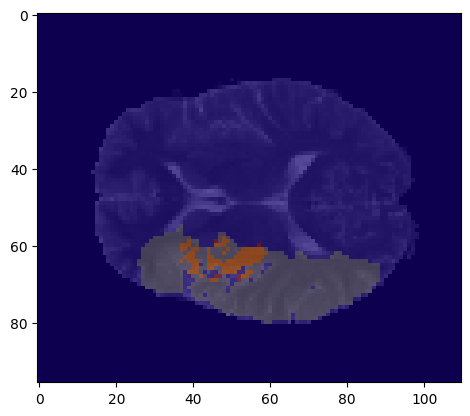

Slice: 35


In [ ]:
BASE_DIR='/content/drive/MyDrive/Stroke data/SPES2015_Training/patient 1/1'
T2_DIR= 'VSD.Brain.XX.O.MR_T2.70151/VSD.Brain.XX.O.MR_T2.70151.nii'
CORE_DIR='corelabel/VSD.Brain.XX.O.OT.70157/VSD.Brain.XX.O.OT.70157.nii'
PENUMB_DIR='penumbralabel/VSD.Brain.XX.O.OT.70159/VSD.Brain.XX.O.OT.70159.nii'
core=nib.load(os.path.join(BASE_DIR,CORE_DIR)).get_fdata()
penumbra=nib.load(os.path.join(BASE_DIR,PENUMB_DIR)).get_fdata()
t2 = nib.load(os.path.join(BASE_DIR,T2_DIR)).get_fdata()
# for i in range(t2.shape[-1]):
for i in range(35,36):
    print('T2 + Core + Penumbra')
    # if len(x.shape) == 4:
    #     test = x[:,:,0,i]
    # elif len(x.shape) == 3:
    #     test = x[:,:,i]
    plt.imshow(t2[:,:,i],cmap='gray')
    plt.imshow(penumbra[:,:,i],alpha=0.4)
    plt.imshow(core[:,:,i],cmap='jet',alpha=0.5)
    # clear_output(wait=True)
    plt.show()
    print('Slice:',i)

#Patient 2

T1 + Lesion


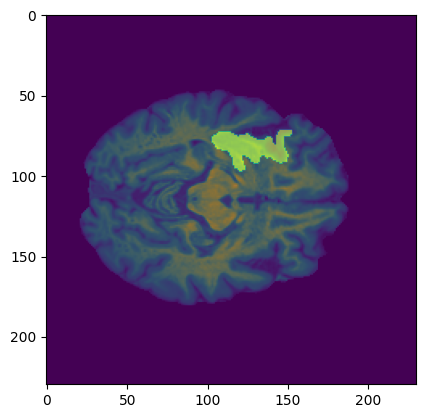

Slice: 69


In [ ]:
# from IPython.display import clear_output
# from time import sleep
BASE_DIR='/content/drive/MyDrive/Stroke data/SISS2015_Training/patient 2/2'
mat = sorted(os.listdir(BASE_DIR))
for mat1 in mat[1:2]:
    if mat1[-4:] == '.mat':
        key = list(loadmat(os.path.join(BASE_DIR,mat1)).keys())[-1]
        # print(key)
        x=loadmat(os.path.join(BASE_DIR,mat1))[key]
        t1 = nib.load(os.path.join(BASE_DIR,'VSD.Brain.XX.O.MR_T1.70621/VSD.Brain.XX.O.MR_T1.70621.nii')).get_fdata()
        # for i in range(x.shape[-1]):
        for i in range(69,70):
            print('T1 + Lesion')
            if len(x.shape) == 4:
                test = x[:,:,:,i]
            elif len(x.shape) == 3:
                test = x[:,:,i]
            plt.imshow(t1[:,:,i])
            plt.imshow(test,alpha=0.5)
            # clear_output(wait=True)
            plt.show()
            print('Slice:',i)
        # clear_output(wait=True)


#Training Model

Image shape: (55, 230, 230)
Mask shape: (55, 230, 230)


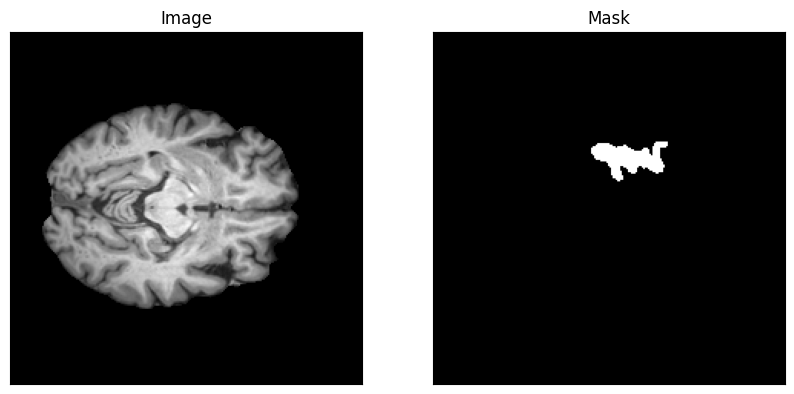

In [ ]:
# BASE_DIR='/content/drive/MyDrive/Stroke data/SPES2015_Training/patient 1/1'
# T2_DIR= 'VSD.Brain.XX.O.MR_T2.70151/VSD.Brain.XX.O.MR_T2.70151.nii'
# CORE_DIR='corelabel/VSD.Brain.XX.O.OT.70157/VSD.Brain.XX.O.OT.70157.nii'
# PENUMB_DIR='penumbralabel/VSD.Brain.XX.O.OT.70159/VSD.Brain.XX.O.OT.70159.nii'

# images = nib.load(os.path.join(BASE_DIR,T2_DIR)).get_fdata()
# masks = nib.load(os.path.join(BASE_DIR,core)).get_fdata()
BASE_DIR='/content/drive/MyDrive/Stroke data/SISS2015_Training/patient 2/2'
images = nib.load(os.path.join(BASE_DIR,'VSD.Brain.XX.O.MR_T1.70621/VSD.Brain.XX.O.MR_T1.70621.nii')).get_fdata()
masks = loadmat(os.path.join(BASE_DIR,'Stroke-2-ImgSeg.mat'))['ImgSeg']

# Create a list to store the indices of non-empty masks
valid_indices=[]
for i in range(masks.shape[-1]):
    if masks[:,:,i].max() > 0:
      valid_indices.append(i)
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images=[]
filtered_masks=[]
for i in valid_indices:
    filtered_images.append(images[:,:,i])
    filtered_masks.append(masks[:,:,i])
filtered_images=np.array(filtered_images)
filtered_masks=np.array(filtered_masks)
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
# dataset_dict = {
#     "image": [Image.fromarray(img) for img in filtered_images],
#     "label": [Image.fromarray(mask) for mask in filtered_masks],
# }
dataset_dict = {
    "image": filtered_images,
    "label": filtered_masks
}


# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

# img_num = random.randint(0, filtered_images.shape[0]-1)
img_num = 10
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)
# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)


In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (230, 230)


In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)


# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

100%|██████████| 28/28 [00:28<00:00,  1.02s/it]


EPOCH: 1
Mean loss: 0.4454221044267927


100%|██████████| 28/28 [00:28<00:00,  1.03s/it]


EPOCH: 2
Mean loss: 0.3657111828880651


100%|██████████| 28/28 [00:28<00:00,  1.00s/it]


EPOCH: 3
Mean loss: 0.3481840097478458


100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


EPOCH: 4
Mean loss: 0.33719092501061304


100%|██████████| 28/28 [00:28<00:00,  1.01s/it]


EPOCH: 5
Mean loss: 0.3281290477940014


100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


EPOCH: 6
Mean loss: 0.31532501322882517


100%|██████████| 28/28 [00:27<00:00,  1.03it/s]


EPOCH: 7
Mean loss: 0.2936976264630045


100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


EPOCH: 8
Mean loss: 0.29585225135087967


100%|██████████| 28/28 [00:27<00:00,  1.01it/s]


EPOCH: 9
Mean loss: 0.2857071581695761


100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


EPOCH: 10
Mean loss: 0.2850050519087485


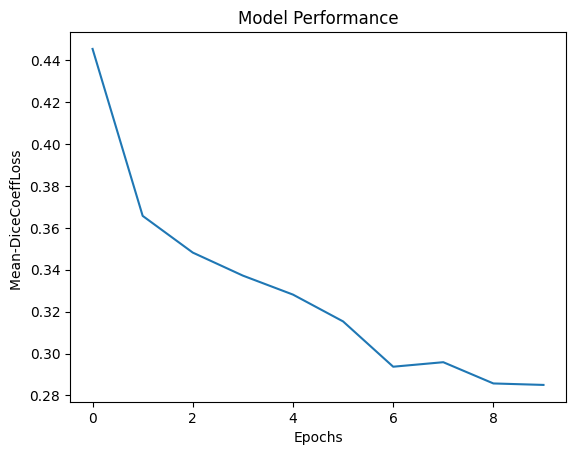

In [ ]:
# from tqdm import tqdm
# from statistics import mean
# import torch
# from torch.nn.functional import threshold, normalize,interpolate

#Training loop
num_epochs = 10
mean_loss = []
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(1,num_epochs+1):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      predicted_masks = interpolate(predicted_masks, size=(230, 230), mode='bilinear', align_corners=False)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    mean_loss.append(mean(epoch_losses))
plt.plot([i for i in range(num_epochs)],mean_loss)
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Mean-DiceCoeffLoss ')
plt.show()

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/SAM_Brain_Checkpoints/vitBase_T1_ImgSeg_epochs10_batch2_checkpoint.pth")

#Loading Model

In [ ]:
# from transformers import SamModel, SamConfig, SamProcessor
# import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/SAM_Brain_Checkpoints/vitBase_T1_ImgSeg_epochs10_batch2_checkpoint.pth"))



<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

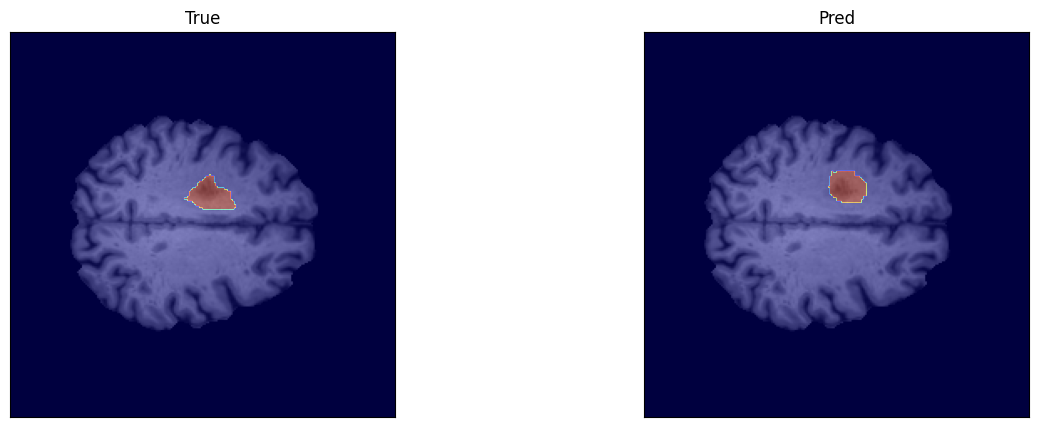

In [ ]:
# import numpy as np
# import random
# import torch
# import matplotlib.pyplot as plt
# from torch.nn.functional import threshold, normalize,interpolate

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)
# idx = 10
# load image
test_image = Image.fromarray(np.array(dataset[idx]["image"]))

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(interpolate(outputs.pred_masks.squeeze(1), size=(230, 230), mode='bilinear', align_corners=False))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze() #not sure what detach does but seems to work. Has something to do with the 'grad' -ability/-ing of a tensor
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].imshow(np.array(ground_truth_mask), cmap='jet', alpha = 0.5)
axes[0].set_title("True")

# # Plot the second image on the right
axes[1].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[1].imshow(medsam_seg, cmap='jet', alpha = 0.5)
axes[1].set_title("Pred")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

#Experiments

In [ ]:
type(example_mask)

PIL.TiffImagePlugin.TiffImageFile

In [ ]:
type(filtered_masks[8])

numpy.ndarray

In [ ]:
def imagify(X):
    ma = np.max(X)
    mi = np.min(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[-1]):
            X[i][j] = (X[i][j]-mi)*255/(ma-mi)
    return X

Image shape: (23, 96, 110, 3)
Mask shape: (23, 96, 110)


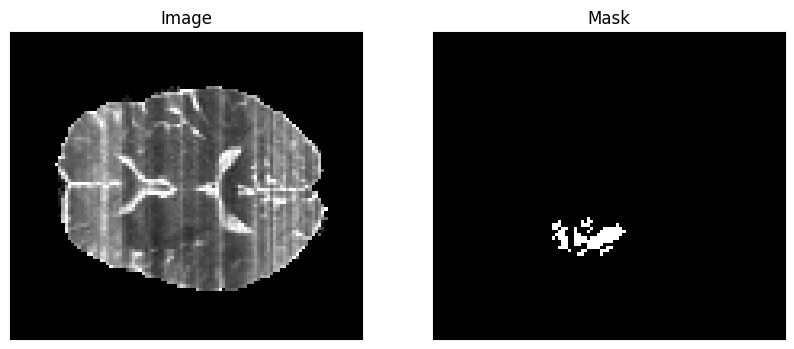

Img: 8


In [ ]:
# # !pip install -q datasets
# # !pip install -q nibabel
# import nibabel as nib
# # import monai

# import numpy as np
# import matplotlib.pyplot as plt
# # from scipy.io import loadmat
# import os
# # from tqdm import tqdm
# # from statistics import mean
# from datasets import Dataset
# from PIL import Image

BASE_DIR='/content/drive/MyDrive/Stroke data/SPES2015_Training/patient 1/1'
T2_DIR= 'VSD.Brain.XX.O.MR_T2.70151/VSD.Brain.XX.O.MR_T2.70151.nii'
TMAX_DIR= 'VSD.Brain.XX.O.MR_Tmax.70152/VSD.Brain.XX.O.MR_Tmax.70152.nii'
DWI_DIR= 'VSD.Brain.XX.O.MR_DWI.70147/VSD.Brain.XX.O.MR_DWI.70147.nii'
CORE_DIR='corelabel/VSD.Brain.XX.O.OT.70157/VSD.Brain.XX.O.OT.70157.nii'
PENUMB_DIR='penumbralabel/VSD.Brain.XX.O.OT.70159/VSD.Brain.XX.O.OT.70159.nii'

t2 = nib.load(os.path.join(BASE_DIR,T2_DIR)).get_fdata()
tmax = nib.load(os.path.join(BASE_DIR,TMAX_DIR)).get_fdata()
dwi= nib.load(os.path.join(BASE_DIR,DWI_DIR)).get_fdata()
images = np.stack((t2,tmax,dwi),axis=2)
masks = nib.load(os.path.join(BASE_DIR,CORE_DIR)).get_fdata()

# images = nib.load(os.path.join(BASE_DIR,DWI_DIR)).get_fdata()
# masks = nib.load(os.path.join(BASE_DIR,CORE_DIR)).get_fdata()


# Create a list to store the indices of non-empty masks
valid_indices=[]
for i in range(masks.shape[-1]):
    if masks[:,:,i].max() > 0:
      valid_indices.append(i)
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images=[]
filtered_masks=[]
for i in valid_indices:
    filtered_images.append(images[:,:,:,i])
    filtered_masks.append(masks[:,:,i])

filtered_images=np.array(filtered_images)
filtered_masks=np.array(filtered_masks)

for i in range(filtered_masks.shape[0]):
    filtered_images[i,:,:,:] = np.stack((MinMaxScaler().fit_transform(filtered_images[i,:,:,0]),MinMaxScaler().fit_transform(filtered_images[i,:,:,1]),MinMaxScaler().fit_transform(filtered_images[i,:,:,2])),axis=-1)
    # filtered_images[i,:,:,1] = imagify(filtered_masks[i][:,:,1])
    # filtered_images[i,:,:,2] = imagify(filtered_masks[i][:,:,2])




print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary

# dataset_dict = {
#     "image": [Image.fromarray(img) for img in filtered_images],
#     "label": [Image.fromarray(mask) for mask in filtered_masks],
# }
dataset_dict = {
    "image": filtered_images,
    "label": filtered_masks
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

# img_num = random.randint(0, filtered_images.shape[0]-1)
img_num = 8
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image)[:,:,2], cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
print('Img:',img_num)

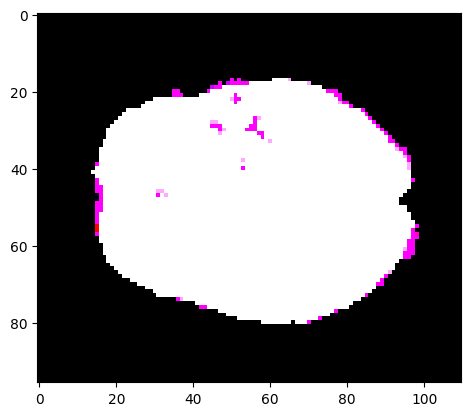

In [ ]:
plt.imshow(np.array(example_image)[:,:,:])
plt.show()

In [ ]:

import numpy as np
X = np.array([[123,234,345],[456,567,678],[789,890,901]])
Y = MinMaxScaler().fit_transform(X)
# def imagify(X):
#     ma = np.max(X)
#     mi = np.min(X)
#     for i in range(X.shape[0]):
#         for j in range(X.shape[-1]):
#             X[i][j] = (X[i][j]-mi)*255/(ma-mi)
#     return X
print(X)
print(Y)

[[123 234 345]
 [456 567 678]
 [789 890 901]]
[[0.         0.         0.        ]
 [0.5        0.50762195 0.59892086]
 [1.         1.         1.        ]]


In [ ]:
t2 = nib.load(os.path.join(BASE_DIR,T2_DIR)).get_fdata()
tmax = nib.load(os.path.join(BASE_DIR,TMAX_DIR)).get_fdata()
dwi= nib.load(os.path.join(BASE_DIR,DWI_DIR)).get_fdata()
print(t2.shape)
np.stack((t2,tmax,dwi),axis=2).shape

(96, 110, 72)


(96, 110, 3, 72)

In [ ]:
ground_truth_map = np.array(dataset[1,12]['label'])
# plt.imshow(ground_truth_map)
# print(ground_truth_map.shape)
# plt.show()
type(ground_truth_map)

<ipython-input-65-8e2886c1e8e7>:1: FutureWarning: The input object of type 'TiffImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'TiffImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ground_truth_map = np.array(dataset[1,12]['label'])
<ipython-input-65-8e2886c1e8e7>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ground_truth_map = np.array(dataset[1,12]['label'])


numpy.ndarray

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class Example_DS(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        record = self.data[idx]

        # X1 = record[:5]
        # X2 = record[5:]

        # X1 = torch.from_numpy(X1)
        # X2 = torch.from_numpy(X2)

        # X = torch.stack([X1, X2])

        # sample = {
        #     'sample' : X
        #     }

        return record


########################################
# data = [
#         np.random.randint(0, 10, 10)
#         ,np.random.randint(0, 10, 10)
#         ,np.random.randint(0, 10, 10)
#         ,np.random.randint(0, 10, 10)
#         ,np.random.randint(0, 10, 10)
#         ,np.random.randint(0, 10, 10)
#         ]


ds = Example_DS(data)

dls = DataLoader(ds, batch_size = 1, shuffle = True, num_workers = 1)

for batch in dls:
    print(batch)

tensor([[9, 5, 9, 1, 0, 5, 5, 9, 1, 1]])
tensor([[2, 2, 7, 8, 1, 6, 4, 7, 9, 9]])
tensor([[4, 8, 6, 9, 7, 8, 7, 3, 4, 1]])
tensor([[3, 5, 6, 5, 3, 0, 5, 5, 5, 5]])
tensor([[9, 2, 9, 7, 0, 0, 7, 2, 2, 8]])
tensor([[7, 1, 4, 9, 9, 0, 7, 9, 3, 6]])


In [ ]:
data

[array([9, 2, 9, 7, 0, 0, 7, 2, 2, 8]),
 array([3, 5, 6, 5, 3, 0, 5, 5, 5, 5]),
 array([4, 8, 6, 9, 7, 8, 7, 3, 4, 1]),
 array([7, 1, 4, 9, 9, 0, 7, 9, 3, 6]),
 array([2, 2, 7, 8, 1, 6, 4, 7, 9, 9]),
 array([9, 5, 9, 1, 0, 5, 5, 9, 1, 1])]

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def imagify(X):
    ma = np.max(X)
    mi = np.min(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[-1]):
            X[i][j] = (X[i][j]-mi)*255/(ma-mi)
    return X

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    items = self.dataset[idx]
    images = items["image"]
    labels = items["label"]
    batch=[]

    for label,image in zip(labels,images):
        ground_truth_mask = np.array(label)
        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(np.array(image), input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        batch.append(inputs)

    return np.array(batch)

In [ ]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)
# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)
# batch = next(iter(train_dataloader))
# for k,v in batch.items():
#   print(k,v.shape)

for batch in train_dataloader:
    print(batch)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)


# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
# from tqdm import tqdm
# from statistics import mean
# import torch
# from torch.nn.functional import threshold, normalize,interpolate

#Training loop
num_epochs = 10
mean_loss = []
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(1,num_epochs+1):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      predicted_masks = interpolate(predicted_masks, size=(230, 230), mode='bilinear', align_corners=False)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    mean_loss.append(mean(epoch_losses))
plt.plot([i for i in range(num_epochs)],mean_loss)
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Mean-DiceCoeffLoss ')
plt.show()

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices=[]
for i in range(masks.shape[-1]):
    if masks[:,:,i].max() > 0:
      valid_indices.append(i)
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images=[]
filtered_masks=[]
for i in valid_indices:
    filtered_images.append(images[:,:,i])
    filtered_masks.append(masks[:,:,i])
filtered_images=np.array(filtered_images)
filtered_masks=np.array(filtered_masks)
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)


Image shape: (23, 96, 110)
Mask shape: (23, 96, 110)


In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 23
})

Let us make sure out images and masks (labels) are loading appropriately

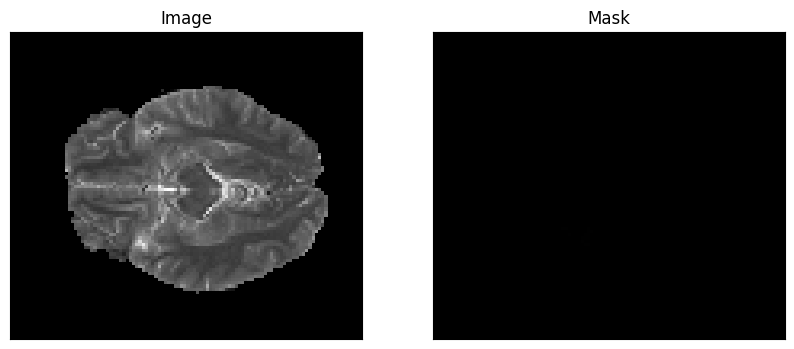

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()